In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from utils import *
from methods import *

In [3]:
from models import Similitude
model = Similitude(ncells=7)

In [4]:
# Train model
nsamples_space = 2**10
loss_history = []
phases_history = [model.phases.clone().detach().numpy()]
for epoch in tqdm.trange(100):
    rs = model.unit_cell.sample(nsamples_space)
    rs = torch.tensor(rs,dtype=torch.float32)
    loss = model.train_step(rs)
    loss_history.append(loss)
    phases_history.append(model.phases.clone().detach().numpy())

100%|█████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.68it/s]


2.014197826385498

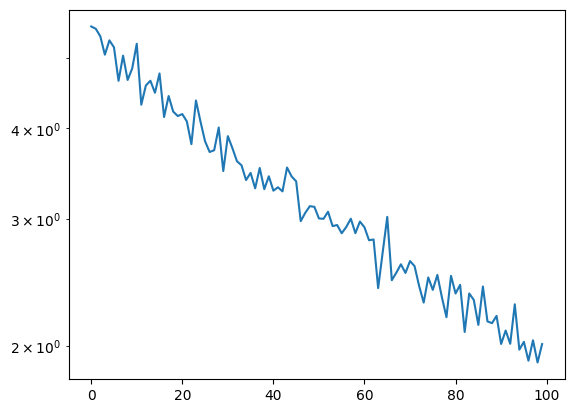

In [5]:
plt.plot(loss_history)
plt.semilogy()
loss_history[-1]

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

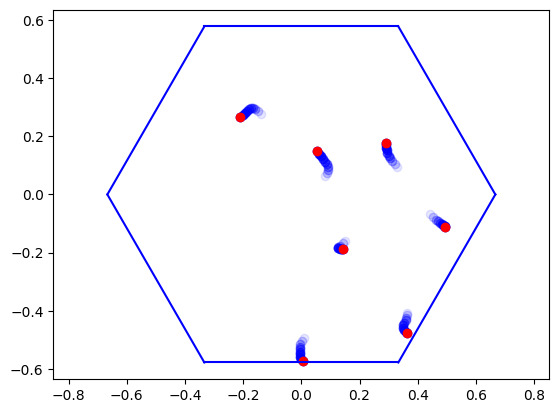

In [6]:
N = len(phases_history)
fig, ax = plt.subplots()
[ax.scatter(*phases_history[i].T, c='blue', alpha=i/N) for i in range(0,N,10)]
ax.scatter(*phases_history[-1].T, c='red')
ax.axis('equal')
model.unit_cell.plot(fig,ax)
#model.unit_cell.plot(fig,ax,center=np.mean(phases_history[-1],axis=0))

In [7]:
torch.save(model,'./optimal-models/JV7')